<a href="https://colab.research.google.com/github/taavip/automatic-control-of-electrical-equipment-basis-of-price/blob/main/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import *
from sklearn.neural_network import *
from sklearn.neighbors import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.model_selection import *
import matplotlib.pyplot as plt

In [2]:
import requests  # Import the requests library

# Query URL
url = ('https://dashboard.elering.ee/api/nps/price?start=2019-12-27T23%3A59%3A59.999Z&end=2020-12-27T23%3A59%3A59.999Z'
       )
# Some api's will have nicer syntax like:
# `&time=2010..2012` or `&na_item=B1GQ,D21`
print(url)

response = requests.get(url)  # Make a GET request to the URL

# Print status code (and associated text)
#print(f"Request returned {response.status_code} : '{response.reason}'")

# Print data returned (parsing as JSON)
payload = response.json()  # Parse `response.text` into JSON

import pprint
pp = pprint.PrettyPrinter(indent=1)
#pp.pprint(payload)
# NOTE: Could use print(response.json()) but this wouldn't be formatted nicely

https://dashboard.elering.ee/api/nps/price?start=2019-12-27T23%3A59%3A59.999Z&end=2020-12-27T23%3A59%3A59.999Z


In [3]:
import pandas as pd

df = pd.json_normalize(payload['data']['ee'])
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['dow'] = pd.to_datetime(df['timestamp'], unit='s').dt.dayofweek
df['hour'] = pd.to_datetime(df['timestamp'], unit='s').dt.hour

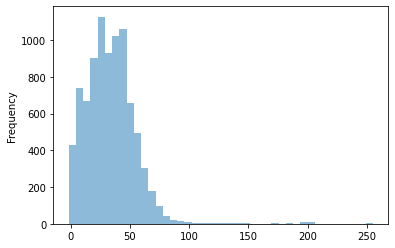

In [4]:
df.price.plot.hist(bins=42, alpha=0.5)

In [5]:
df['price'].mean()

33.59550519465691

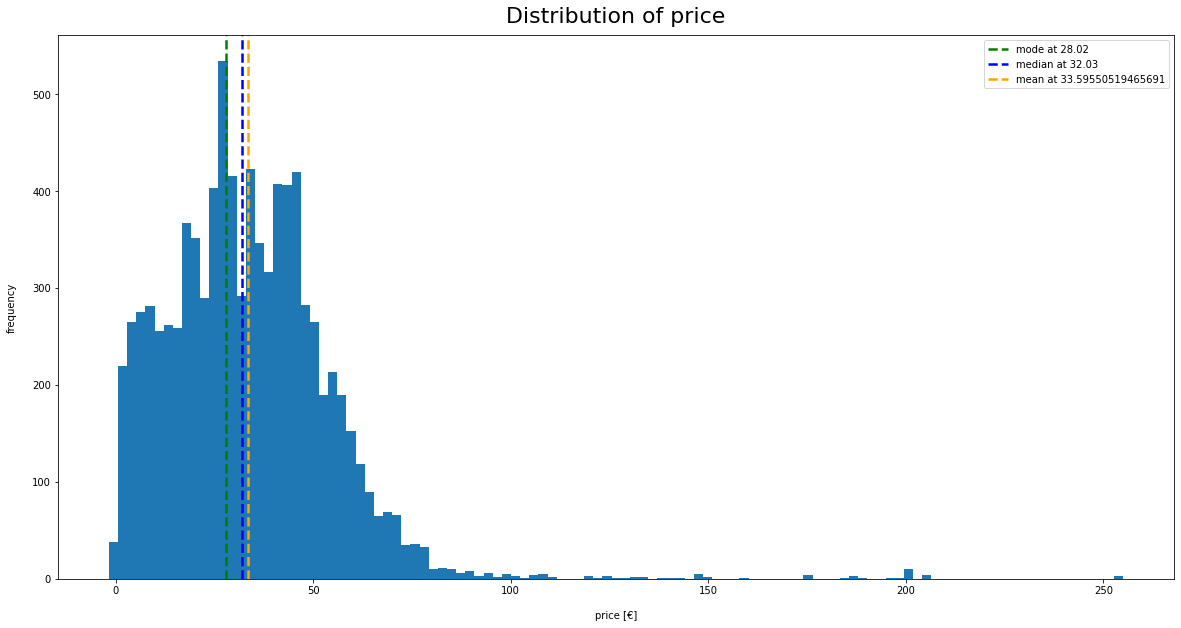

In [6]:
#df['price'].plot(kind='hist', figsize=(10, 8), linewidth=2, color='whitesmoke', edgecolor='gray')
plt.figure(figsize=(20,10))
plt.hist(df['price'], bins=111 )

plt.xlabel("price [€]", labelpad=15)
plt.ylabel("frequency", labelpad=15)
#plt.xscale('log')
#plt.yscale('log')
plt.title("Distribution of price", y=1.012, fontsize=22)
measurements = [df['price'].mode()[0], df['price'].median(), df['price'].mean()]
names = ["mode", "median", "mean"]
colors = ['green', 'blue', 'orange']
for measurement, name, color in zip(measurements, names, colors):
    plt.axvline(x=measurement, linestyle='--', linewidth=2.5, label='{0} at {1}'.format(name, measurement), c=color)
plt.legend();

In [7]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true+abs(y_true.min()), y_pred+abs(y_true.min()))
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [8]:
data = df.copy()
# creating new dataframe from consumption column
data_consumption = df.copy()
# inserting new column with yesterday's consumption values
data_consumption.loc[:,'1h'] = data_consumption.loc[:,'price'].shift()
# inserting another column with difference between yesterday and day before yesterday's consumption values.
data_consumption.loc[:,'1h_Diff'] = data_consumption.loc[:,'1h'].diff()

data_consumption['avg24h'] = data_consumption.price.rolling(window=24,min_periods=1).mean()
# dropping NAs
data_consumption = data_consumption.dropna()


In [9]:

len(data_consumption[:int(len(data_consumption[:])*0.8)])

7005

In [10]:
num = int(len(data_consumption[:])*0.8)
print(num)
X_train = data_consumption[:num].drop(['price', 'datetime'], axis = 1)
y_train = data_consumption.loc[:num+1, 'price']
X_test = data_consumption[num:].drop(['price','datetime'], axis = 1)
y_test = data_consumption.loc[num+2:, 'price']

7005


In [11]:
y_train

2       30.82
3       30.53
4       30.46
5       31.60
6       32.99
        ...  
7002    20.17
7003    19.21
7004    19.64
7005    17.32
7006    16.53
Name: price, Length: 7005, dtype: float64

LR: 0.754026 (0.051813)
NN: -0.058258 (0.350298)
KNN: -0.710313 (0.640801)
RF: 0.702692 (0.105855)
SVR: -0.157769 (0.198470)


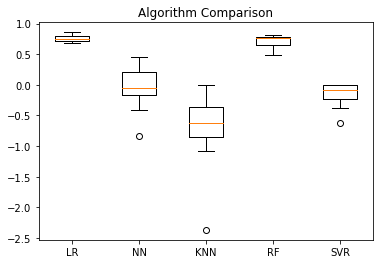

In [12]:


# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=10)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *


model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'neg_mean_squared_error')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [14]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.7539
mean_squared_log_error:  0.1604
r2:  0.7518
MAE:  8.1426
MSE:  200.4777
RMSE:  14.159


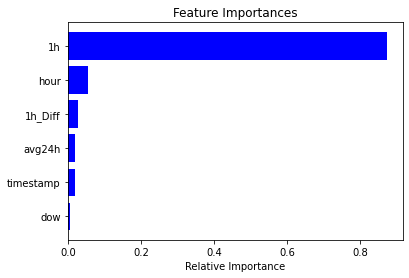

In [15]:
imp = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

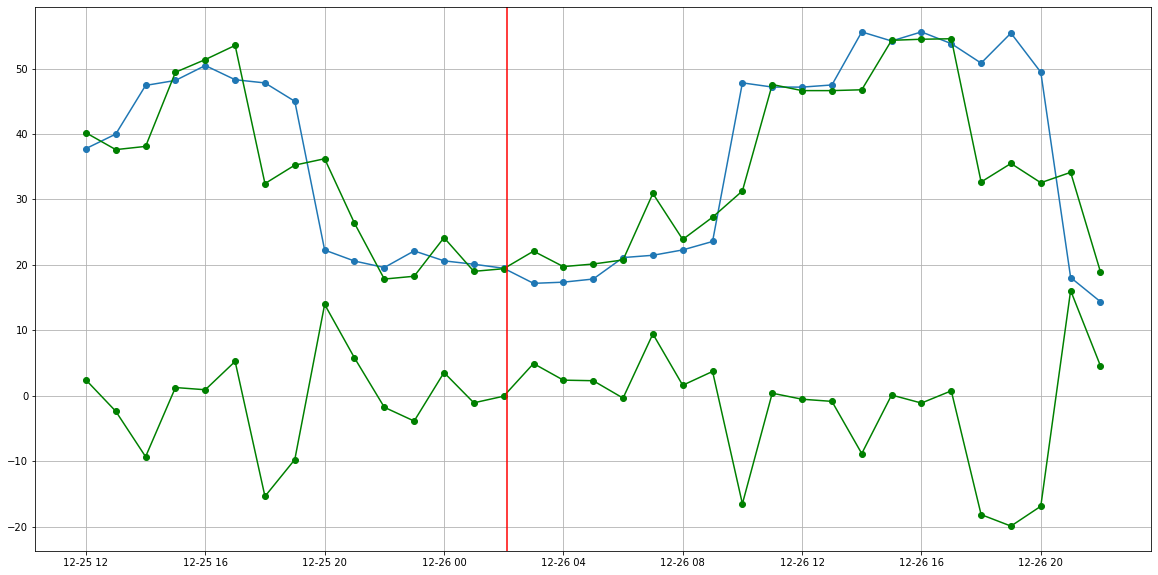

In [16]:
a =df.loc[:,['price','datetime']][-35:]

plt.figure(figsize=(20,10))
plt.plot(pd.to_datetime(a.datetime).dt.tz_localize('Europe/Tallinn'), a.price,  marker='o')
plt.plot(pd.to_datetime( X_test['timestamp'][-35:], unit='s').dt.tz_localize('Europe/Tallinn'), best_model.predict(X_test)[-35:],  marker='o',color='green')
plt.plot(pd.to_datetime( X_test['timestamp'][-35:], unit='s').dt.tz_localize('Europe/Tallinn'), best_model.predict(X_test)[-35:]-a.price,  marker='o',color='green')
plt.grid(b=None, which='major', axis='both')
plt.axvline(x= pd.Timestamp.now(tz = 'Europe/Tallinn'), color='red')